In [10]:
import sys
from pathlib import Path
import os
import warnings
import time
import re
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
ANAYLSIS_OUTPUT_ROOTDIR = os.getenv("ANALYSIS_OUTPUT_ROOTDIR")
DATA_ROOTDIR = os.getenv("DATA_ROOTDIR")
sys.path.append(SPIKECOUNTER_PATH)
import matplotlib as mpl
from matplotlib import patches, colors
import colorcet as cc
from cycler import cycler

import numpy as np
import skimage.io as skio
from scipy import ndimage, signal, stats, fft, interpolate, optimize
from scipy.special import ndtr
from skimage import exposure, measure, filters, transform, morphology, draw
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statannotations.Annotator import Annotator
import statsmodels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd
import mat73
import pandas as pd
import parse
import pickle

from spikecounter.analysis import traces, images
from spikecounter.analysis import stats as sstats
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils

warnings.filterwarnings("once")
plt.style.use(
    os.path.join(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
)
ss = StandardScaler()

In [2]:
expt_name = "20221005_overdrive_suppression_pacing"
rootdir = Path(DATA_ROOTDIR, expt_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure5/", expt_name)

### Load metadata and video

In [6]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20221005_overdrive_suppression_pacing/"
subfolder = "corrected"
um_per_px = 0.265*4
os.makedirs(os.path.join(rootdir, "analysis"), exist_ok=True)

In [7]:
expt_metadata = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, "experiment_data.csv"))

In [7]:
# expt_metadata.to_csv(os.path.join(rootdir, "analysis", subfolder, "experiment_data.csv"))

In [8]:
expts_by_embryo = expt_metadata.set_index("embryo").loc[[3,4,7,13,19,24]]
expts_by_embryo = expts_by_embryo[~expts_by_embryo["endogenous"]]

In [9]:
dfs = []
for i in range(expts_by_embryo.shape[0]):
    file_name = expts_by_embryo.iloc[i]["file_name"]
    embryo = expts_by_embryo.index[i]
    offset = expts_by_embryo.iloc[i]["offset"]
    df = pd.read_csv(os.path.join(rootdir, "analysis", subfolder, file_name, "wave_data.csv"))
    df["embryo"] = embryo
    df["offset"] = offset
    dfs.append(df)

In [10]:
all_data = pd.concat(dfs, axis=0)

In [11]:
all_data.to_csv(os.path.join(figdir, "Data", "locus_pacing_normed_activation_time.csv"))

In [4]:
all_data = pd.read_csv(output_datadir/"locus_pacing_normed_activation_time.csv")

In [16]:
all_data = all_data.set_index(["embryo", "stim_interval"]).sort_index(ascending=[True, False,True])

### Plot individual spike LOIs

/tmp/ipykernel_161579/338026432.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  expt_data = all_data.loc[idx]
/tmp/ipykernel_161579/338026432.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(figsize=(6,6))


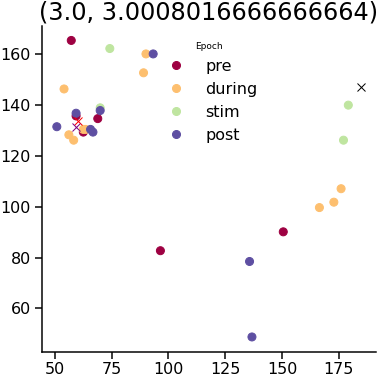

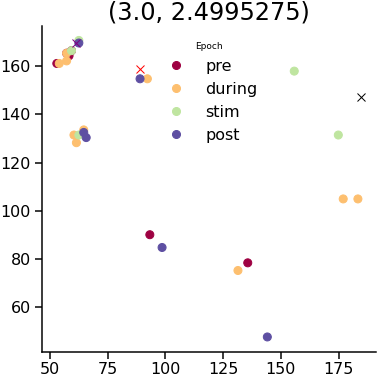

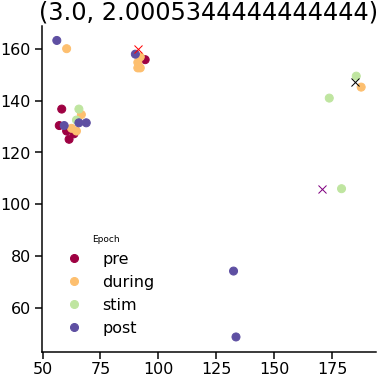

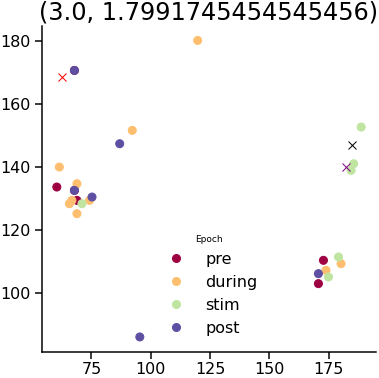

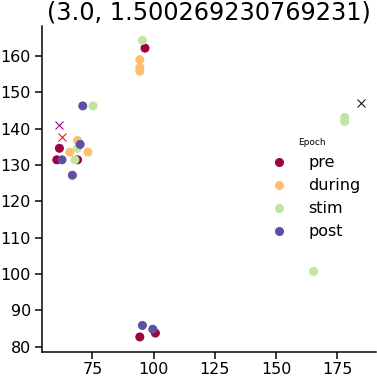

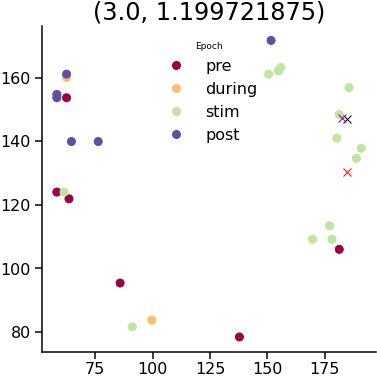

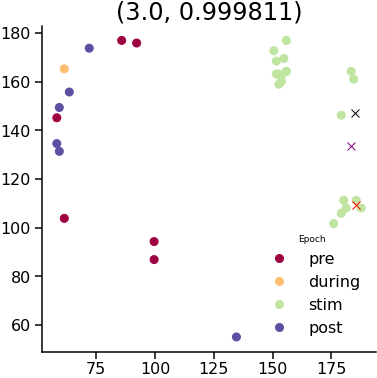

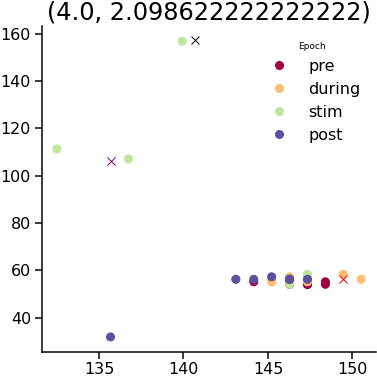

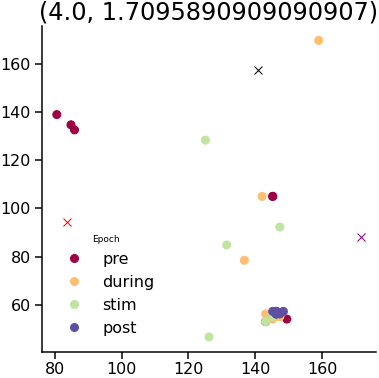

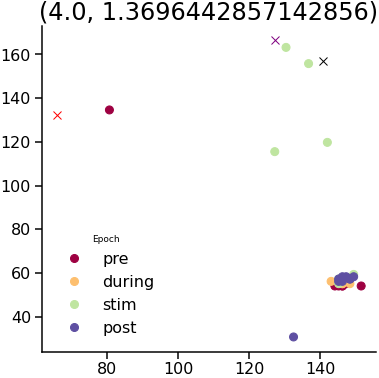

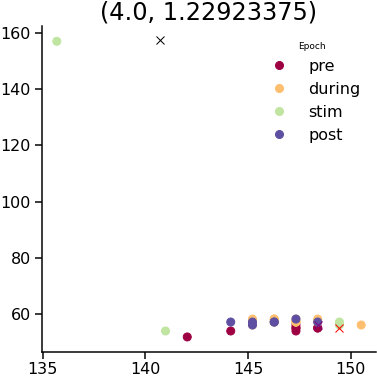

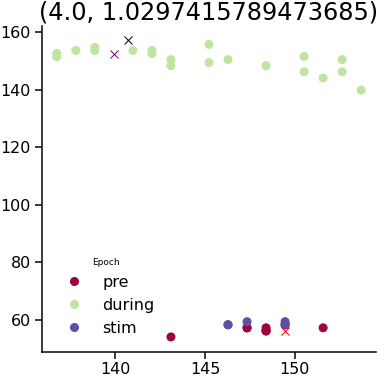

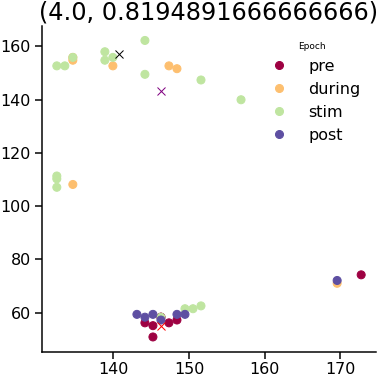

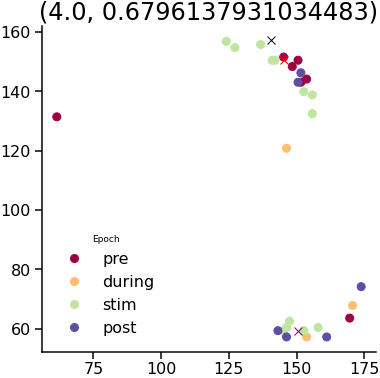

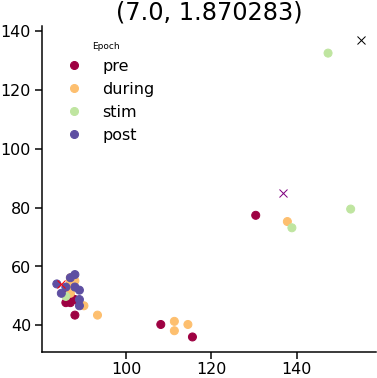

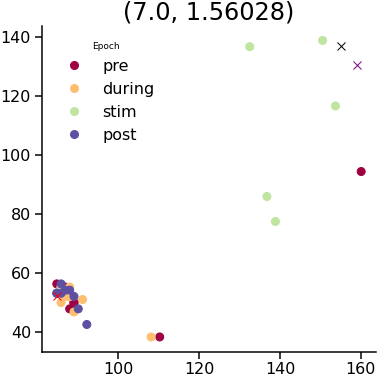

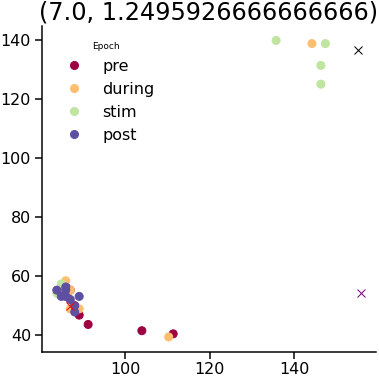

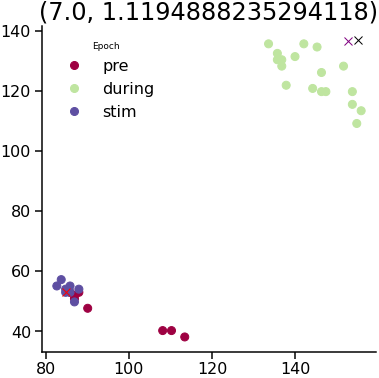

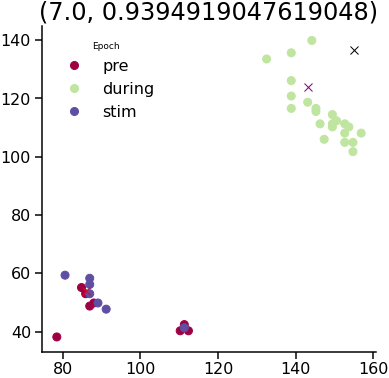

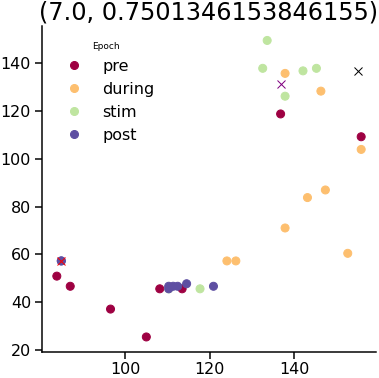

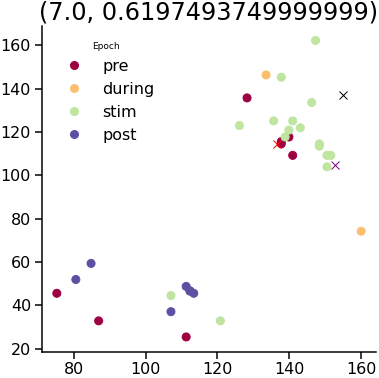

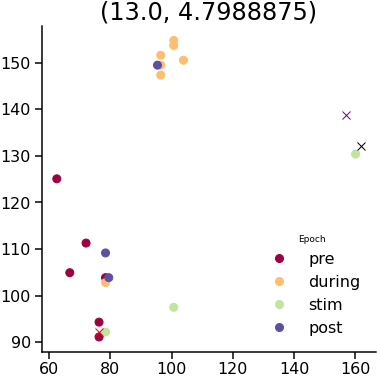

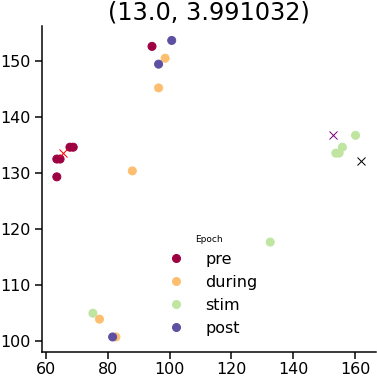

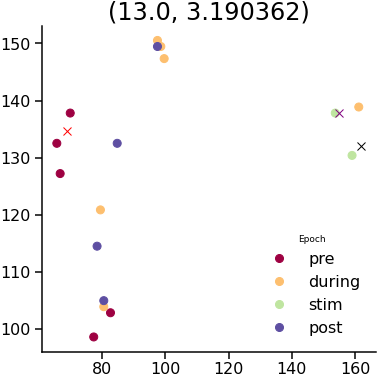

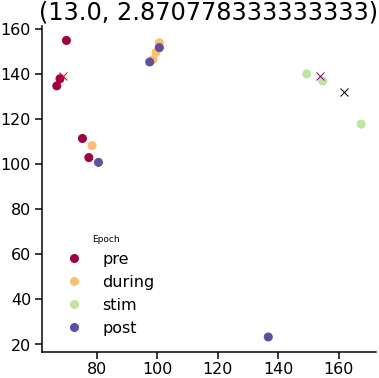

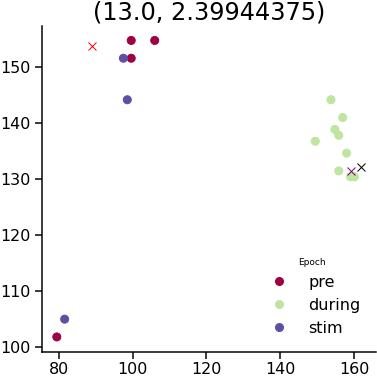

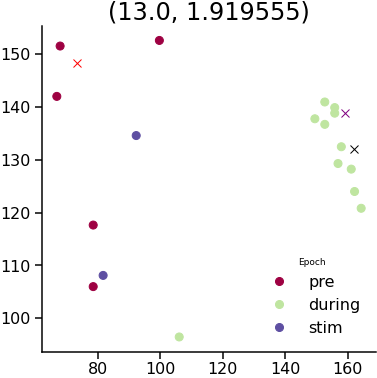

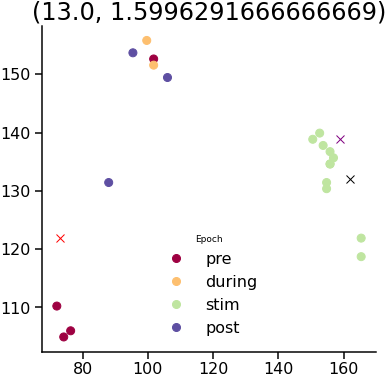

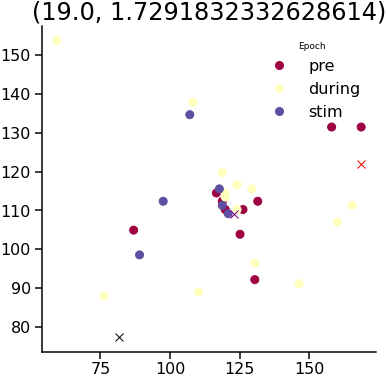

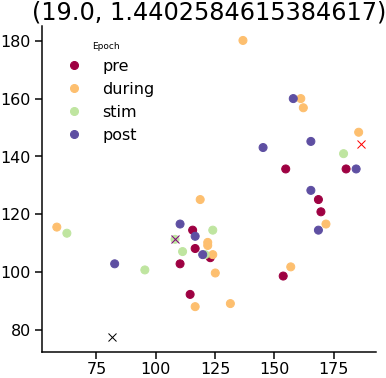

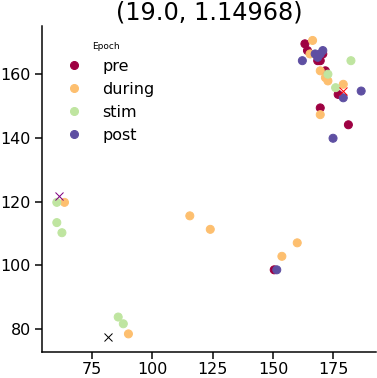

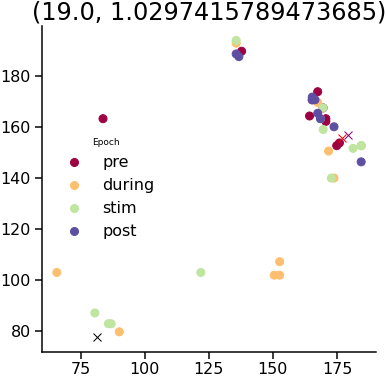

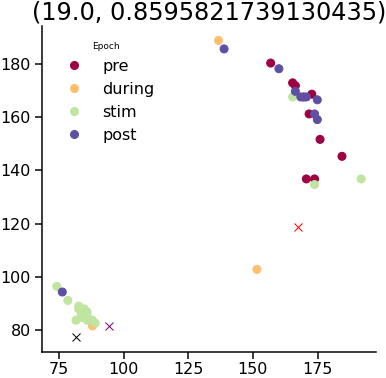

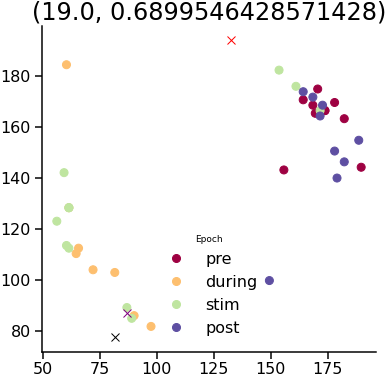

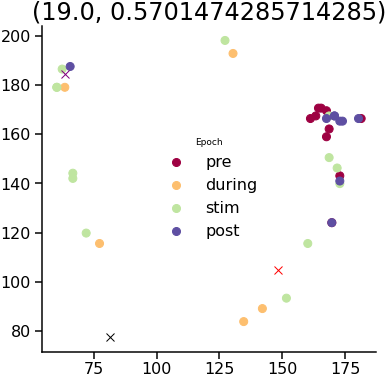

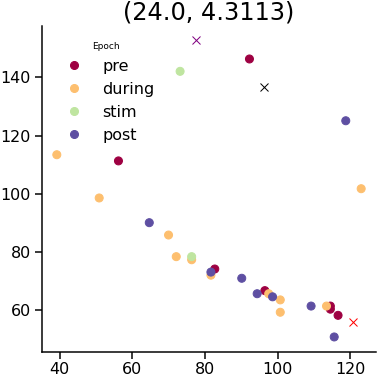

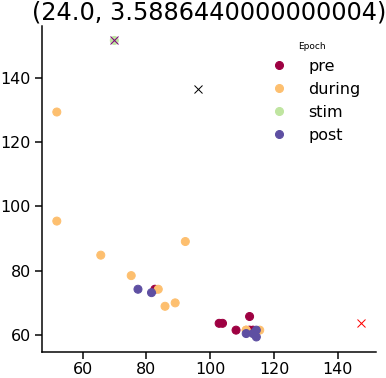

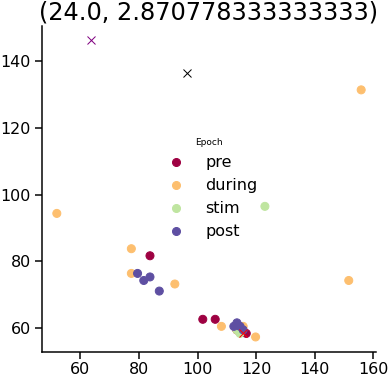

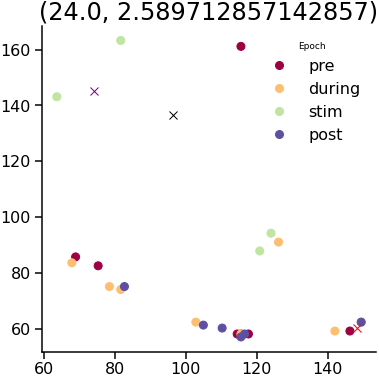

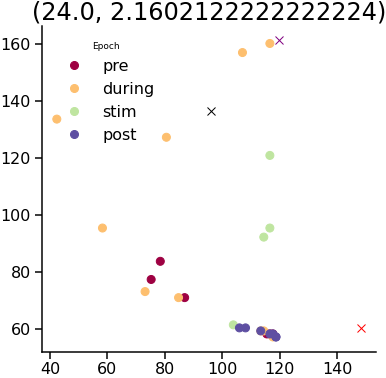

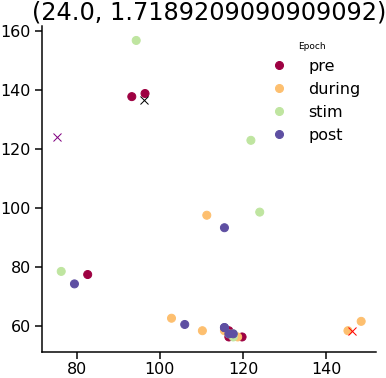

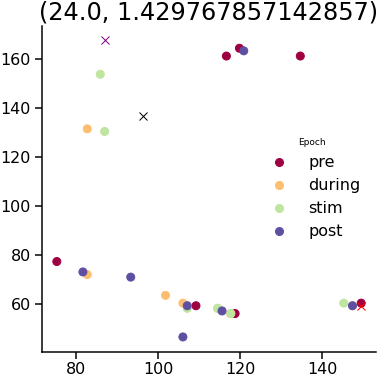

In [22]:
plt.close("all")
for idx in all_data.index.unique():
    expt_data = all_data.loc[idx]
    fig1, ax1 = plt.subplots(figsize=(6,6))
    sc = ax1.scatter(expt_data["x_loi_test"], expt_data["y_loi_test"],\
                     c=[conditions[k] for k in expt_data["condition"].to_list()])
    ax1.legend(handles = sc.legend_elements()[0], \
               labels=keys, title="Epoch")
    ax1.set_title(idx)
    ax1.plot(expt_data["x_target"].iloc[0], expt_data["y_target"].iloc[0], "kx")
    ax1.plot(expt_data["x_loi_pre"].iloc[0], expt_data["y_loi_pre"].iloc[0], "rx")
    ax1.plot(expt_data["x_loi_stim"].iloc[0], expt_data["y_loi_stim"].iloc[0], "x", color="purple")

In [13]:
all_data

,condition,time,offset_nearest_stim,diff_pre,diff_stim,x_loi_test,y_loi_test,dist_to_pre_loi,dist_to_stim_loi,dist_to_target,...,x_loi_stim,y_loi_stim,loi_dist_pre,loi_dist_stim,t_loi,t_target,x_target,y_target,embryo,offset
0,pre,2.11028,NaN,0.055166,0.042264,96.46,82.68,62.351071,61.269467,109.299750,...,59.36,131.44,125.106654,126.404711,0.922473,131.522854,184.797750,147.045188,3.0,2219
1,pre,3.58844,NaN,0.094557,0.056583,150.52,90.10,100.033902,100.095660,66.465920,...,59.36,131.44,125.106654,126.404711,0.922473,131.522854,184.797750,147.045188,3.0,2219
2,pre,4.65600,NaN,0.033946,0.039506,68.90,134.62,8.545993,10.056043,116.561888,...,59.36,131.44,125.106654,126.404711,0.922473,131.522854,184.797750,147.045188,3.0,2219
3,pre,5.99045,NaN,0.032227,0.038615,57.24,165.36,31.958604,33.986185,128.865868,...,59.36,131.44,125.106654,126.404711,0.922473,131.522854,184.797750,147.045188,3.0,2219
4,pre,7.46861,NaN,0.048732,0.037514,62.54,129.32,4.740464,3.821884,123.535985,...,59.36,131.44,125.106654,126.404711,0.922473,131.522854,184.797750,147.045188,3.0,2219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,post,34.17814,NaN,0.003336,0.036002,147.34,59.36,2.120000,123.856816,92.533406,...,86.92,167.48,93.720719,32.346223,1.557650,238.952825,96.243883,136.506731,24.0,10111
24,post,35.53312,NaN,0.010423,0.040321,107.06,59.36,42.400000,109.979789,77.901261,...,86.92,167.48,93.720719,32.346223,1.557650,238.952825,96.243883,136.506731,24.0,10111
25,post,36.84704,NaN,0.016898,0.043084,120.84,163.24,107.750447,34.183973,36.326803,...,86.92,167.48,93.720719,32.346223,1.557650,238.952825,96.243883,136.506731,24.0,10111
26,post,38.36626,NaN,0.010252,0.036919,81.62,73.14,69.225386,94.488759,65.032304,...,86.92,167.48,93.720719,32.346223,1.557650,238.952825,96.243883,136.506731,24.0,10111


In [19]:
expt_wise_data = all_data[["isi_before", "isi_during", "isi_after", "loi_dist_pre",\
                           "loi_dist_stim", "offset", "t_loi", "t_target", "x_target",\
                           "y_target", "x_loi_pre", "y_loi_pre", "x_loi_stim",\
                        "y_loi_stim"]].drop_duplicates().reset_index().set_index("embryo")

### Check experiment wise data

Progression of endogenous activity over time

<AxesSubplot:xlabel='offset', ylabel='isi_before'>

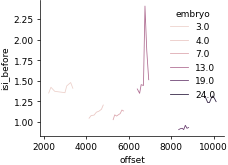

In [16]:
sns.lineplot(data=expt_wise_data, x="offset", y="isi_before",hue="embryo")

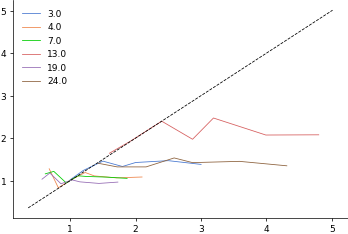

In [17]:
fig1, ax1 = plt.subplots(figsize=(6,4))

for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo].reset_index()
    ax1.plot(embryo_data["stim_interval"], embryo_data["isi_during"], label=embryo)
x = np.linspace(*ax1.get_xlim(), 100)
ax1.plot(x,x, "k--")
ax1.legend()

In [32]:
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")

#### Compare response time versus drive frequency

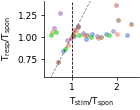

In [111]:
fig1, ax1 = plt.subplots(figsize=(1.7,1.4))

for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo].reset_index()
    ax1.scatter(embryo_data["stim_interval"]/embryo_data["isi_before"], embryo_data["isi_during"]/embryo_data["isi_before"],\
                label=embryo, alpha=0.5, s=14)
x = np.linspace(0.4, 2.5)
ax1.plot(x,x, "k--",alpha=0.5)
ax1.set_xlim(0.4, 2.5)
ax1.set_ylim(0.55,1.42)
# ax1.legend()
# plt.tight_layout()
ax1.set_xlabel(r"$\mathrm{T_{stim}/T_{spon}}$")
ax1.set_ylabel(r"$\mathrm{T_{resp}/T_{spon}}$")
ax1.axvline(1, linestyle="--", color="k")
plt.savefig(os.path.join(figdir, "Supplementary Figures", "overdrive_pacing", "response_vs_drive_freq.svg"))

#### Check what fraction of peaks are evoked by a pulse

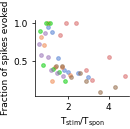

In [110]:
fig1, ax1 = plt.subplots(figsize=(1.7,1.4))
for embryo in all_data.index.unique("embryo"):
    pk_type_count =all_data.loc[embryo].groupby(["condition","stim_interval"]).size()
    evoked_ratio = pk_type_count.loc["stim"]/(pk_type_count.loc["stim"] + pk_type_count.loc["during"])
#     print(evoked_ratio)
    evoked_ratio[np.isnan(evoked_ratio)] = 1
    ax1.scatter(evoked_ratio.index, evoked_ratio,\
               label=embryo, alpha=0.5, s=14)
ax1.set_xlabel(r"$\mathrm{T_{stim}/T_{spon}}$")
ax1.set_ylabel(r"Fraction of spikes evoked")
plt.savefig(os.path.join(figdir, "Supplementary Figures", "overdrive_pacing", "evoked_ratio.svg"))

In [8]:
data_by_cond = all_data.set_index("condition")
for idx in data_by_cond.index.unique():
    print(idx, stats.shapiro(data_by_cond.loc[idx, "dist_to_target"]))

pre ShapiroResult(statistic=0.9077873229980469, pvalue=9.752928716369458e-13)
during ShapiroResult(statistic=0.9550747871398926, pvalue=3.9097255211117954e-08)
stim ShapiroResult(statistic=0.8341480493545532, pvalue=4.545591661489816e-19)
post ShapiroResult(statistic=0.9243719577789307, pvalue=9.542464735057266e-11)


In [6]:
all_data.groupby("condition").size()

condition
during    309
post      281
pre       306
stim      363
dtype: int64

In [ ]:
x="condition"
y="dist_to_target"

fig1, ax1 = plt.subplots(figsize=(3,1.5))
order  = ["pre", "during", "stim", "post"]
# hue_order = ["-", "+"]

# for idx in ss_first.index.unique():
#     offset = 0.5
#     x1 = 0.5-offset
#     x2 = 0.5+offset
#     ax1.plot([x1, x2], [ss_first.loc[idx][y], ss_later.loc[idx][y]], ".-", color="k", alpha=0.2)
#     sns.swarmplot(data=freq_compare, x=x, y=y,ax=ax1, order=order, palette=["k"], size=3, hue=hue_title, dodge=True)
#     sns.barplot(data=freq_compare, x=x, y=y,ax=ax1, order=order, palette=cs, hue=hue_title,\
#                hue_order=hue_order)
sns.boxplot(data=all_data, x=x, y=y,ax=ax1, order=order, boxprops={"alpha": 0.8}, fliersize=0)
ax1.set_xlabel("")
ax1.set_xticklabels(["Pre", "Spon.", "Evoked", "Post"])
ax1.set_ylabel(r"Distance to target ($\mathrm{\mu m}$)")

#     print(ax1.get_xticks())
#     sns.barplot(x=x, y=y, hue=hue_title,\
#                 data = freq_compare, ax=ax1, ci="sd", order=order,\
#                hue_order=hue_order, capsize=0.05)

# ax1.set_ylim(-0.05, 1.5)
# ax1.set_xlabel("Time after \n onset (min)")
# ax1.set_ylabel("Mean rel. spike \n amplitude")
pairs = [("pre", "stim"), ("during", "stim"), ("post", "stim")]
# # for patch, color in zip(bplot['boxes'], cs):
# #     patch.set_facecolor(color)
# #     ax1.set_yticks([0,0.5,1,1.5,2])
annot = Annotator(ax1, pairs, data=all_data, x=x,y=y, order=order)
annot.configure(test="Mann-Whitney", verbose=2, comparisons_correction="BH")
annot.apply_and_annotate()
ax1.annotate("During stimulus \nperiod", xy=(0.5, -0.25), xytext = (0.5, -0.6), xycoords="axes fraction",\
             ha="center", arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=0.65', lw=1.5, ))

# plt.ti
plt.savefig(os.path.join(output_datadir, "target_distance_by_class.svg"))

#### ?

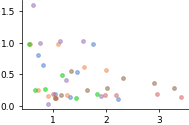

In [32]:
fig1, ax1 = plt.subplots(figsize=(3,2))

for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo].reset_index()
    ax1.scatter(embryo_data["stim_interval"]/embryo_data["isi_before"], embryo_data["loi_dist_stim"]/embryo_data["loi_dist_pre"],\
                label=embryo, alpha=0.5, s=14)
# x = np.linspace(0.4, 2.5)

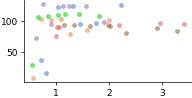

In [61]:
fig1, ax1 = plt.subplots(figsize=(3,1.5))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo].reset_index()
    ax1.scatter(embryo_data["stim_interval"]/embryo_data["isi_before"], embryo_data["loi_dist_pre"],\
                label=embryo, alpha=0.5, s=14)

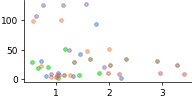

In [62]:
fig1, ax1 = plt.subplots(figsize=(3,1.5))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo].reset_index()
    ax1.scatter(embryo_data["stim_interval"]/embryo_data["isi_before"], embryo_data["loi_dist_stim"],\
                label=embryo, alpha=0.5, s=14)

#### Show that the LOI is not moved towards the target over time

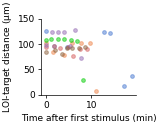

In [102]:
fig1, ax1 = plt.subplots(figsize=(1.7,1.4))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo].reset_index()
    ax1.scatter((embryo_data["offset"]-embryo_data["offset"].iloc[0])/60, embryo_data["loi_dist_pre"],\
                label=embryo, alpha=0.5, s=14)
ax1.set_xlabel("Time after first stimulus (min)")
ax1.set_ylim([0, 150])
ax1.set_ylabel(r"LOI-target distance ($\mathrm{\mu m}$)")
plt.savefig(os.path.join(figdir, "Supplementary Figures", "overdrive_pacing", "loi_memoryless.svg"))

In [77]:
embryo_data = expt_wise_data.loc[embryo]

In [83]:
np.linalg.norm(np.array([embryo_data["x_loi_pre"] - embryo_data["x_loi_pre"].iloc[0],\
          embryo_data["y_loi_pre"] - embryo_data["y_loi_pre"].iloc[0]]), axis=0)

array([  0.        ,  38.29227076,  40.5856822 ,  35.04418354,
         4.74046411, 124.06076253, 127.43386834])

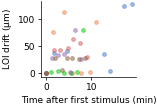

In [103]:
fig1, ax1 = plt.subplots(figsize=(1.7,1.4))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo].reset_index()
    ax1.scatter((embryo_data["offset"]-embryo_data["offset"].iloc[0])/60,\
            np.linalg.norm(np.array([embryo_data["x_loi_pre"] - embryo_data["x_loi_pre"].iloc[0],\
              embryo_data["y_loi_pre"] - embryo_data["y_loi_pre"].iloc[0]]), axis=0),\
                label=embryo, alpha=0.5, s=14)
ax1.set_xlabel("Time after first stimulus (min)")
ax1.set_ylabel(r"LOI drift ($\mathrm{\mu m}$)")
plt.savefig(os.path.join(figdir, "Supplementary Figures", "overdrive_pacing", "loi_memoryless_drift.svg"))

/tmp/ipykernel_202136/1652570246.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_202136/1652570246.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]


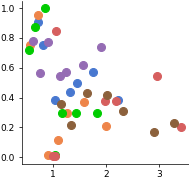

In [24]:
fig1, ax1 = plt.subplots(figsize=(3,3))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo]
    x = []
    y = []
    for st in embryo_data.index.unique("stim_interval"):
        try:
            d1 = all_data.loc[(embryo, st, "during")]
        except KeyError:
            d1 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        try:
            d2 = all_data.loc[(embryo, st, "stim")]
        except KeyError:
            d2 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        
        paced_stimuli = pd.concat([d1, d2], axis=0)
        frac_paced = np.sum(paced_stimuli["diff_stim"] < paced_stimuli["diff_pre"])/paced_stimuli.shape[0]
        x.append(st/embryo_data["isi_before"].loc[st])
        y.append(frac_paced)
    ax1.scatter(x, y)

/tmp/ipykernel_202136/596517679.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_202136/596517679.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]


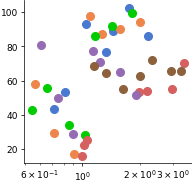

In [26]:
fig1, ax1 = plt.subplots(figsize=(3,3))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo]
    x = []
    y = []
    for st in embryo_data.index.unique("stim_interval"):
        try:
            d1 = all_data.loc[(embryo, st, "during")]
        except KeyError:
            d1 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        try:
            d2 = all_data.loc[(embryo, st, "stim")]
        except KeyError:
            d2 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        
        paced_stimuli = pd.concat([d1, d2], axis=0)
        mean_loi_dist_target = np.mean(paced_stimuli["dist_to_target"])
        x.append(st/embryo_data["isi_before"].loc[st])
        y.append(mean_loi_dist_target)
    ax1.scatter(x, y)
# ax1.set_xscale("log")

/tmp/ipykernel_202136/4073887280.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_202136/4073887280.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]
/tmp/ipykernel_202136/4073887280.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_202136/4073887280.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]
/tmp/ipykernel_202136/4073887280.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_202136/4073887280.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]
/tmp/ipykernel_202136/4073887280.py:9: PerformanceWarning: indexing past 

(0.0, 2.0)

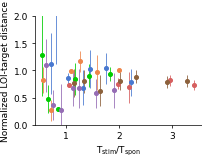

In [74]:
fig1, ax1 = plt.subplots(figsize=(3,2))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo]
    x = []
    y = []
    y_std = []
    for st in embryo_data.index.unique("stim_interval"):
        try:
            d1 = all_data.loc[(embryo, st, "during")]
        except KeyError:
            d1 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        try:
            d2 = all_data.loc[(embryo, st, "stim")]
        except KeyError:
            d2 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        
        paced_stimuli = pd.concat([d1, d2], axis=0)
        mean_loi_dist_target = np.mean(paced_stimuli["dist_to_target"]/embryo_data["loi_dist_pre"].loc[st])
#         break
        x.append(st/embryo_data["isi_before"].loc[st])
        y.append(mean_loi_dist_target)
        y_std.append(np.std(paced_stimuli["dist_to_target"]/embryo_data["loi_dist_pre"].loc[st]))
    ax1.errorbar(x, y, yerr=y_std, fmt="o", markersize=4)
ax1.set_xlabel(r"$\mathrm{T_{stim}/T_{spon}}$")
ax1.set_ylabel("Normalized LOI-target distance")
ax1.set_ylim(0, 2)

/tmp/ipykernel_202136/1387067784.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_202136/1387067784.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]
/tmp/ipykernel_202136/1387067784.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_202136/1387067784.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]
/tmp/ipykernel_202136/1387067784.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_202136/1387067784.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]
/tmp/ipykernel_202136/1387067784.py:9: PerformanceWarning: indexing past 

(0.0, 2.0)

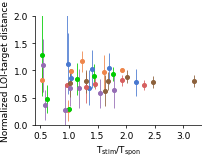

In [75]:
fig1, ax1 = plt.subplots(figsize=(3,2))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo]
    x = []
    y = []
    y_std = []
    for st in embryo_data.index.unique("stim_interval"):
        try:
            d1 = all_data.loc[(embryo, st, "during")]
        except KeyError:
            d1 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        try:
            d2 = all_data.loc[(embryo, st, "stim")]
        except KeyError:
            d2 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        
        paced_stimuli = pd.concat([d1, d2], axis=0)
        mean_loi_dist_target = np.mean(paced_stimuli["dist_to_target"]/embryo_data["loi_dist_pre"].loc[st])
#         break
        x.append(st/embryo_data["isi_during"].loc[st])
        y.append(mean_loi_dist_target)
        y_std.append(np.std(paced_stimuli["dist_to_target"]/embryo_data["loi_dist_pre"].loc[st]))
    ax1.errorbar(x, y, yerr=y_std, fmt="o", markersize=4)
ax1.set_xlabel(r"$\mathrm{T_{stim}/T_{spon}}$")
ax1.set_ylabel("Normalized LOI-target distance")
ax1.set_ylim(0, 2)

/tmp/ipykernel_99499/3140798886.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_99499/3140798886.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]
/tmp/ipykernel_99499/3140798886.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_99499/3140798886.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]
/tmp/ipykernel_99499/3140798886.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  d1 = all_data.loc[(embryo, st, "during")]
/tmp/ipykernel_99499/3140798886.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  d2 = all_data.loc[(embryo, st, "stim")]
/tmp/ipykernel_99499/3140798886.py:11: PerformanceWarning: indexing past lex

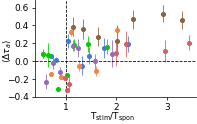

In [21]:
fig1, ax1 = plt.subplots(figsize=(3,2))
all_xs = []
all_ys = []
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo]
    x = []
    y = []
    y_std = []
    for st in embryo_data.index.unique("stim_interval"):
        try:
            d1 = all_data.loc[(embryo, st, "during")]
        except KeyError:
            d1 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        try:
            d2 = all_data.loc[(embryo, st, "stim")]
        except KeyError:
            d2 = pd.DataFrame([], columns=all_data.columns, index=all_data.index)
        
        paced_stimuli = pd.concat([d1, d2], axis=0)
        mean_loi_dist_target = np.mean(paced_stimuli["t_test_target"]-paced_stimuli["t_test_loi"])
#         break
        x.append(float(st/embryo_data["isi_before"].loc[st]))
        y.append(mean_loi_dist_target)
        y_std.append(stats.sem(paced_stimuli["t_test_target"]-paced_stimuli["t_test_loi"]))
    all_xs.extend(x)
    all_ys.extend(y)
    ax1.errorbar(x, y, yerr=y_std, fmt="o", markersize=4)
# all_xs = np.array(all_xs)
# all_ys = np.array(all_ys)
# window = 0.2
# overlap = 0.075
# n_ticks = int(np.round((np.max(all_xs) - np.min(all_xs))/(window-overlap)))
# xticks = np.linspace(np.min(all_xs), np.max(all_xs), n_ticks)
# ma_values = []
# for xtick in xticks:
#     ma_values.append(np.nanmean(all_ys[(all_xs < xtick+window/2) & (all_xs >= xtick-window/2)]))
# ma_values = np.array(ma_values)
# xticks = xticks[np.isfinite(ma_values)]
# ma_values = ma_values[np.isfinite(ma_values)]
# ax1.plot(xticks, ma_values, color="k", zorder=1000, linewidth=2)
ax1.set_xlabel(r"$\mathrm{T_{stim}/T_{spon}}$")
ax1.set_yticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6])
ax1.axhline(0, linestyle="--", color="k")
ax1.set_ylabel(r"$\langle \Delta \tau_a \rangle$")
ax1.yaxis.set_label_coords(-0.14,0.48)
ax1.xaxis.set_label_coords(0.48,-0.14)
ax1.axvline(1, linestyle="--", color="k")


plt.tight_layout()
# ax1.set_ylim(-200)
plt.savefig(os.path.join(figdir, "Supplementary Figures", "overdrive_pacing", "loi_rewriting_activation_time.svg"))

In [109]:
ref_xs = expt_wise_data.reset_index()["stim_interval"].values/expt_wise_data.reset_index()["isi_before"].values

In [56]:
print(y)

[0.8072070510780986, 0.7814916926498864, 0.8787420003586695, 0.8018758626293279, 0.626844951401914, 0.7985058958696077, 0.7682156369911223]


In [52]:
pre_spikes

time  offset_nearest_stim  diff_pre  \
embryo stim_interval condition                                           
24.0   1.429768      pre        1.92551                  NaN  0.012875   
                     pre        3.11625                  NaN  0.004263   
                     pre        4.40964                  NaN  0.013916   
                     pre        5.76462                  NaN  0.009751   
                     pre        6.91430                  NaN  0.006959   
                     pre        8.10504                  NaN  0.003424   
                     pre        9.39843                  NaN  0.002734   

                                diff_stim  x_loi_test  y_loi_test  \
embryo stim_interval condition                                      
24.0   1.429768      pre         0.055816          72          73   
                     pre         0.067658         113         155   
                     pre         0.055766         103          56   
                     pre         0.087806         111          54   
                     pre         0.068286         110         152   
                     pre         0.067344         141          57   
                     pre         0.072245         113          53   

                                dist_to_pre_loi  dist_to_stim_loi  \
embryo stim_interval condition                                      
24.0   1.429768      pre              76.485293         54.341513   
                     pre             102.786186         41.012193   
                     pre              44.045431         72.532751   
                     pre              36.221541         76.896034   
                     pre             101.019800         36.769553   
                     pre               6.082763         89.498603   
                     pre              34.365681         78.549348   

                                dist_to_target                  file_name  \
embryo stim_interval condition                                              
24.0   1.429768      pre             67.976987  105733E24_overdrive_1.43s   
                     pre             24.955329  105733E24_overdrive_1.43s   
                     pre             80.789720  105733E24_overdrive_1.43s   
                     pre             83.815892  105733E24_overdrive_1.43s   
                     pre             20.718883  105733E24_overdrive_1.43s   
                     pre             91.238316  105733E24_overdrive_1.43s   
                     pre             85.171249  105733E24_overdrive_1.43s   

                                ...  isi_before  isi_during  isi_after  \
embryo stim_interval condition  ...                                      
24.0   1.429768      pre        ...    1.245487    1.408674   1.372088   
                     pre        ...    1.245487    1.408674   1.372088   
                     pre        ...    1.245487    1.408674   1.372088   
                     pre        ...    1.245487    1.408674   1.372088   
                     pre        ...    1.245487    1.408674   1.372088   
                     pre        ...    1.245487    1.408674   1.372088   
                     pre        ...    1.245487    1.408674   1.372088   

                                x_loi_pre  y_loi_pre  x_loi_stim  y_loi_stim  \
embryo stim_interval condition                                                 
24.0   1.429768      pre              147         58          84         126   
                     pre              147         58          84         126   
                     pre              147         58          84         126   
                     pre              147         58          84         126   
                     pre              147         58          84         126   
                     pre              147         58          84         126   
                     pre              147         58          84         126   

                                loi_dist_p

In [45]:
embryo_data

,,isi_before,isi_during,isi_after,loi_dist_pre,loi_dist_stim,offset
stim_interval,condition,,,,,,
4.311300,during,1.310498,1.349381,1.410704,85.373613,24.421859,9589
3.588644,during,1.235222,1.453897,1.375510,87.643399,30.933073,9714
2.870778,during,1.235222,1.424035,1.381376,82.498883,36.274632,9798
2.589713,during,1.283125,1.534151,1.404252,90.751959,26.248519,9875
2.160212,during,1.313920,1.323395,1.331028,90.691273,22.821236,9940
1.718921,during,1.289284,1.323395,1.358402,91.580132,51.001551,10025
1.429768,during,1.245487,1.408674,1.372088,93.485241,16.133942,10111


In [34]:
pre_spikes["dist_to_target"]

embryo  stim_interval  condition
24.0    1.429768       pre          67.976987
                       pre          24.955329
                       pre          80.789720
                       pre          83.815892
                       pre          20.718883
                       pre          91.238316
                       pre          85.171249
Name: dist_to_target, dtype: float64

/tmp/ipykernel_202136/1308934855.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pre_spikes = all_data.loc[(embryo, st, "pre")]
/tmp/ipykernel_202136/1308934855.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pre_spikes = all_data.loc[(embryo, st, "pre")]
/tmp/ipykernel_202136/1308934855.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pre_spikes = all_data.loc[(embryo, st, "pre")]
/tmp/ipykernel_202136/1308934855.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pre_spikes = all_data.loc[(embryo, st, "pre")]
/tmp/ipykernel_202136/1308934855.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pre_spikes = all_data.loc[(embryo, st, "pre")]
/tmp/ipykernel_202136/1308934855.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pre_spikes = all_data.loc[(embryo, st, "pre")]


Text(0, 0.5, 'Normalized LOI-target distance')

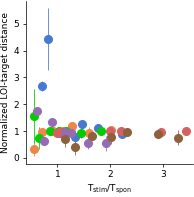

In [70]:
fig1, ax1 = plt.subplots(figsize=(3,3))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo]
    x = []
    y = []
    y_std = []
    for st in embryo_data.index.unique("stim_interval"):
        pre_spikes = all_data.loc[(embryo, st, "pre")]
#         print(pre_spikes)
        mean_loi_dist_target = np.nanmean(pre_spikes["dist_to_target"].values/embryo_data["loi_dist_pre"].loc[st].values)
        
        x.append(st/embryo_data["isi_before"].loc[st])
        y.append(mean_loi_dist_target)
        y_std.append(np.nanstd(pre_spikes["dist_to_target"].values/embryo_data["loi_dist_pre"].loc[st].values))
#     break
#     print(x)
#     print(y)
    ax1.errorbar(x, y, yerr=y_std, fmt="o")
#     print(x,y)
#     ax1.scatter(x,y)
ax1.set_xlabel(r"$\mathrm{T_{stim}/T_{spon}}$")
ax1.set_ylabel("Normalized LOI-target distance")

/tmp/ipykernel_202136/3379996865.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  pre_spikes = all_data.loc[(embryo, st, "pre")]


Text(0, 0.5, 'Normalized LOI-target distance')

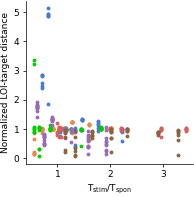

In [72]:
fig1, ax1 = plt.subplots(figsize=(3,3))
for embryo in expt_wise_data.index.unique("embryo"):
    embryo_data = expt_wise_data.loc[embryo]
    x = []
    y = []
#     y_std = []
    for st in embryo_data.index.unique("stim_interval"):
        pre_spikes = all_data.loc[(embryo, st, "pre")]
#         print(pre_spikes)
        loi_dist_target = list(pre_spikes["dist_to_target"].values/embryo_data["loi_dist_pre"].loc[st].values)
        norm_period = [st/embryo_data["isi_before"].loc[st]]*len(loi_dist_target)
        x.extend(norm_period)
        y.extend(loi_dist_target)
#         y_std.append(np.nanstd(pre_spikes["dist_to_target"].values/embryo_data["loi_dist_pre"].loc[st].values))
#     break
#     print(x)
#     print(y)
#     ax1.errorbar(x, y, yerr=y_std, fmt="o")
#     print(x,y)
    ax1.scatter(x,y, s=8)
ax1.set_xlabel(r"$\mathrm{T_{stim}/T_{spon}}$")
ax1.set_ylabel("Normalized LOI-target distance")

In [42]:
embryo_data["loi_dist_pre"]

stim_interval  condition
4.311300       during       85.373613
3.588644       during       87.643399
2.870778       during       82.498883
2.589713       during       90.751959
2.160212       during       90.691273
1.718921       during       91.580132
1.429768       during       93.485241
Name: loi_dist_pre, dtype: float64

In [41]:
pre_spikes["dist_to_target"]/

stim_interval  condition  embryo
1.429768       during     NaN      NaN
               pre        24.0     NaN
                          24.0     NaN
                          24.0     NaN
                          24.0     NaN
                          24.0     NaN
                          24.0     NaN
                          24.0     NaN
1.718921       during     NaN      NaN
2.160212       during     NaN      NaN
2.589713       during     NaN      NaN
2.870778       during     NaN      NaN
3.588644       during     NaN      NaN
4.311300       during     NaN      NaN
dtype: float64

Representative image

In [104]:
expt_metadata

,embryo,start_time,file_name,offset,period,endogenous,OD,overdrive,snap_file
0,1.0,08:09:02,080902E1_fullfov,0,NaN,False,NaN,False,NaN
1,1.0,08:13:02,081302E1_endogenous,240,NaN,True,NaN,False,NaN
2,3.0,08:33:51,083351E3_endogenous,1489,NaN,True,NaN,False,083155E3_snap.tiff
3,3.0,08:46:01,084601E3_overdrive_3s,2219,3.00,False,NaN,True,083155E3_snap.tiff
4,3.0,08:47:46,084746E3_overdrive_2.5s,2324,2.50,False,NaN,True,083155E3_snap.tiff
5,3.0,08:50:44,085044E3_overdrive_2s,2502,2.00,False,NaN,True,083155E3_snap.tiff
6,3.0,08:58:48,085848E3_overdrive_1.8s,2986,1.80,False,NaN,True,083155E3_snap.tiff
7,3.0,09:00:10,090010E3_overdrive_1.5s,3068,1.50,False,NaN,True,083155E3_snap.tiff
8,3.0,09:03:16,090316E3_overdrive_1.2s,3254,1.20,False,NaN,True,083155E3_snap.tiff
9,3.0,09:04:59,090459E3_overdrive_1s,3357,1.00,False,NaN,True,083155E3_snap.tiff


In [115]:
rep_sample = expt_metadata.iloc[15]

In [116]:
beta_stim = np.load(os.path.join(rootdir, "analysis", subfolder, "%s_snapt_evoked.npz" % rep_sample["file_name"]))["beta"]
beta_pre = np.load(os.path.join(rootdir, "analysis", subfolder, "%s_snapt_pre_stim.npz" % rep_sample["file_name"]))["beta"]

In [117]:
dt = 0.02053

In [118]:
q_pre = images.analyze_wave_dynamics(beta_pre, dt, um_per_px, deltax=13)
q_stim = images.analyze_wave_dynamics(beta_stim, dt, um_per_px, deltax=13)

In [119]:
img, expt_data = images.load_image(rootdir, rep_sample["file_name"], subfolder=subfolder)
traces_dict, t = utils.traces_to_dict(expt_data)

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20221005_overdrive_suppression_pacing/corrected/092525E4_overdrive_1.03s/Sq_camera.bin'


In [120]:
nkx_path = rep_sample["snap_file"]
nkx = skio.imread(os.path.join(rootdir, "Snaps", nkx_path))
factor = 4
nkx_downsample = transform.downscale_local_mean(nkx, (factor,factor))
offset = [(nkx_downsample.shape[0]-img.shape[1])//2, (nkx_downsample.shape[1]-img.shape[2])//2]
if offset[0] > 0:
    nkx_downsample = nkx_downsample[offset[0]:-offset[0],offset[1]:-offset[1]]
mean_intensity = img.mean(axis=0)

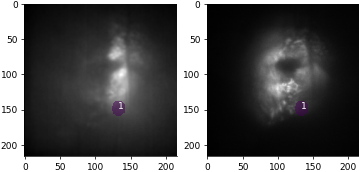

In [121]:
factor = 4
fig1, axes = plt.subplots(1,2, figsize=(6,3))
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
# plt.imshow(target_img_space)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
target_img_space = target_img_space.astype(bool)
q = visualize.display_roi_overlay(mean_intensity, target_img_space.astype(int), ax=axes[0])
q2 = visualize.display_roi_overlay(nkx_downsample, target_img_space.astype(int), ax=axes[1])

In [122]:
tsmoothed_stim = np.copy(q_stim[2])
tsmoothed_stim -= np.nanpercentile(tsmoothed_stim, 2)
tsmoothed_pre = np.copy(q_pre[2])
tsmoothed_pre -= np.nanpercentile(tsmoothed_pre, 2)

In [127]:
strel = morphology.disk(6)
edges = feature.canny(np.nan_to_num(target_img_space.astype(float)), sigma=2)
edges = morphology.binary_closing(edges, footprint=strel)
edges = morphology.binary_dilation(edges, footprint=morphology.disk(1))
edges = np.ma.masked_array(edges, mask=~edges)

In [129]:
# colormap for edges of ROI 1
cmatrix = np.zeros((3,2,3))
cmatrix[:,1,0] = 1
cmatrix[:,0,1:3] = np.array([0,0,0])[:,None]/255
cmatrix[:,1,1:3] = np.array([121,67,142])[:,None]/255

cdict = {'red':   cmatrix[0].tolist(),
         'green': cmatrix[1].tolist(),
         'blue':  cmatrix[2].tolist()}

cmp2 = colors.LinearSegmentedColormap('testCmap2', segmentdata=cdict, N=256)

287.3760256673543


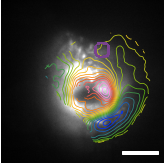

In [144]:
fig1, ax1 = plt.subplots(figsize=(3,3))

im = ax1.contour(tsmoothed_pre, vmin=0, \
               vmax=np.nanpercentile(tsmoothed_pre,99), levels=16, \
                 cmap = plt.get_cmap("cet_CET_R1"))
vmax = np.nanpercentile(tsmoothed_pre,99)
alpha=1
target_mask = np.ma.masked_where(target_img_space==0, target_img_space)
ax1.imshow(nkx_downsample, cmap="gray", vmax=np.percentile(nkx_downsample, 99))
ax1.imshow(edges,interpolation='none', cmap=cmp2, vmin=0,vmax=1, zorder=5)

# ax1.imshow(target_mask, interpolation='none', alpha=alpha, cmap="cet_CET_L15",\
#            vmin=0, vmax = np.max(target_img_space), zorder=4)
norm = mpl.colors.Normalize(vmin=0, \
               vmax=vmax)
print(vmax)

plt.gca().invert_yaxis()
# cax = plt.axes([0.13, 0.06, 0.75, 0.05])
# cb1 = mpl.colorbar.ColorbarBase(cax, cmap=im.cmap, norm=norm, orientation="horizontal")
# cb1.set_label("Activation time (ms)")
# cax.xaxis.set_ticks([0,100,200])

ax1.set_axis_off()
visualize.plot_img_scalebar(fig1, ax1, 160, 12, 50, 4,\
                pix_per_um=1/um_per_px, yax_direction="up", show_label=False)
plt.savefig(os.path.join(figdir, "Supplementary Figures", "overdrive_pacing", "spontaneous_activation_map.tif"), dpi=600)

258.0059451034787


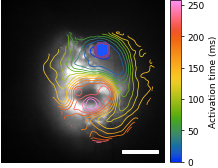

In [145]:
fig1, ax1 = plt.subplots(figsize=(3,3))

im = ax1.contour(tsmoothed_stim, vmin=0, \
               vmax=np.nanpercentile(tsmoothed_stim,99), levels=16, \
                 cmap = plt.get_cmap("cet_CET_R1"))
vmax = np.nanpercentile(tsmoothed_stim,99)
alpha=1
target_mask = np.ma.masked_where(target_img_space==0, target_img_space)
ax1.imshow(nkx_downsample, cmap="gray", vmax=np.percentile(nkx_downsample, 99))
ax1.imshow(target_mask, interpolation='none', alpha=alpha, cmap="cet_CET_L15",\
           vmin=0, vmax = np.max(target_img_space), zorder=4)
ax1.imshow(edges,interpolation='none', cmap=cmp2, vmin=0,vmax=1, zorder=5)
norm = mpl.colors.Normalize(vmin=0, \
               vmax=vmax)
print(vmax)

plt.gca().invert_yaxis()
cax = plt.axes([0.92, 0.13, 0.05, 0.75])
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=im.cmap, norm=norm)
cb1.set_label("Activation time (ms)")
cax.yaxis.set_ticks([0, 50, 100, 150, 200, 250])

ax1.set_axis_off()
visualize.plot_img_scalebar(fig1, ax1, 160, 12, 50, 4,\
                pix_per_um=1/um_per_px, yax_direction="up", show_label=False)
plt.savefig(os.path.join(figdir, "Supplementary Figures", "overdrive_pacing", "paced_activation_map.tif"), dpi=600)